# Navier-Stokes: flow around a cylinder

https://hplgit.github.io/fenics-tutorial/pub/sphinx1/._ftut1004.html#flow-past-a-cylinder
OMP_NUM_THREADS=4 python cylinderSplit.py

In [1]:
from scipy.sparse import linalg
from math import sqrt
import matplotlib.pyplot as plt
import pygmsh
from dune.alugrid import aluConformGrid as GridView
from dune.ufl import Constant, DirichletBC
from dune.fem.space import lagrange
from dune.fem.scheme import galerkin
from ufl import (
    FacetNormal,
    Identity,
    SpatialCoordinate,
    TestFunction,
    TrialFunction,
    conditional,
    div,
    dot,
    ds,
    dx,
    inner,
    nabla_grad,
    sqrt,
    sym,
    triangle,
)

Setup parameters for simulation:

In [2]:
order = 2
tau = Constant(1 / 2000, "tau")      # time step
mu  = Constant(0.001, "mu")          # kinematic viscosity
rho = Constant(1, "rho")             # density

Use pygmsh to define domain with cylinder

In [3]:
with pygmsh.occ.Geometry() as geom:
    geom.set_mesh_size_callback( lambda dim, tag, x, y, z, lc:
        min(0.02+1.5*( (x-0.2)**2+(y-0.2)**2), 0.04)
    )
    rectangle = geom.add_rectangle([0, 0, 0], 2.2, 0.41)
    cylinder = geom.add_disk([0.2, 0.2, 0.0], 0.05)
    geom.boolean_difference(rectangle, cylinder)
    mesh = geom.generate_mesh()
    points, cells = mesh.points, mesh.cells_dict
    # extract dictionary for grid construction
    domain = {
        "vertices": points[:, :2].astype(float),
        "simplices": cells["triangle"].astype(int),
    }
gridView = GridView(domain)
print("grid size:", gridView.size(0),flush=True)

grid size: 1410


Setup spaces for Taylor-Hood and required discrete functions and UFL
coefficients:

In [4]:
space_u = lagrange( gridView, order=order, dimRange=2)
space_p = lagrange( gridView, order=order-1)

u = TrialFunction(space_u)
v = TestFunction(space_u)
p = TrialFunction(space_p)
q = TestFunction(space_p)
x = SpatialCoordinate(space_p)

u_h = space_u.interpolate([0, 0], name="u_h")
u_h_n = u_h.copy(name="u_h_n")

p_h = space_p.interpolate(0, name="p_h")
p_h_n = p_h.copy(name="p_h_n")

Now setup model - one time step is split into three linear parts.
First some general definitions:

In [5]:
inflow = [6 * x[1] * (0.41 - x[1]) / 0.41**2, 0] # 6->18
dbc_u_in = DirichletBC(space_u, inflow, x[0] <= 1e-8)
dbc_u_noflow = DirichletBC(space_u, [0, 0], None)
dbc_u_out = DirichletBC(space_u, [None,None], 2.2 - x[0] <= 1e-8)
dbc_p_out = DirichletBC(space_p, 0, 2.2 - x[0] <= 1e-8)

# Define strain-rate tensor
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2 * mu * epsilon(u) - p * Identity(len(u))

# Define expressions used in variational forms
U = 0.5 * (u_h_n + u)
f = Constant((0, 0), "f")

Step 1:

In [6]:
E1 = (
    rho * dot((u - u_h_n) / tau, v) * dx
    + rho * dot(dot(u_h_n, nabla_grad(u_h_n)), v) * dx
    + inner(sigma(U, p_h_n), epsilon(v)) * dx
    - rho * dot(f, v) * dx
) == 0
scheme1 = galerkin( [E1, dbc_u_in,dbc_u_out,dbc_u_noflow] )

Step 2:

In [7]:
E2 = (
    dot(nabla_grad(p-p_h_n), nabla_grad(q)) * dx
    + (1 / tau) * div(u_h_n) * q * dx
) == 0
scheme2 = galerkin([E2, dbc_p_out] )

Step 3:

In [8]:
E3 = (
    dot(u, v) * dx
    - dot(u_h_n, v) * dx
    + tau * dot(nabla_grad(p_h - p_h_n), v) * dx
) == 0
scheme3 = galerkin( [E3, dbc_u_in,dbc_u_out,dbc_u_noflow] )

Next we assemble the matrices for all three steps and precompute the LU
decomposition for each one to speedup the simulation:

In [9]:
def invA(A):
    Ainv = linalg.splu(A.tocsc())
    return lambda b: Ainv.solve(b.as_numpy[:])
A1    = scheme1.linear().as_numpy
A1inv = invA(A1)
A2    = scheme2.linear().as_numpy
A2inv = invA(A2)
A3    = scheme3.linear().as_numpy
A3inv = invA(A3)

zero_u = space_u.interpolate([0,0],name="zero")
zero_p = space_p.interpolate(0,name="zero")
rhs_u  = zero_u.copy(name="rhs")
rhs_p  = zero_p.copy(name="rhs")

To show the solution we make use of the _animate_ module of _matplotlib_.
Here is the `stepping` functions:

In [10]:
def init():
    data = u_h.pointData(1)
    C = plt.tricontourf(triangulation, data[:,0], cmap=plt.cm.rainbow, levels=levels)
    return C.axes.collections
def animate(count):
    global t,stepsize,nextstep
    nextstep += stepsize
    while t < nextstep:
        u_h_n.assign(u_h)
        p_h_n.assign(p_h)
        scheme1(zero_u,rhs_u)
        rhs_u.as_numpy[:] *= -1
        scheme1.setConstraints(rhs_u)
        u_h.as_numpy[:] = A1inv(rhs_u)
        u_h_n.assign(u_h)

        scheme2(zero_p,rhs_p)
        rhs_p.as_numpy[:] *= -1
        try:
            scheme2.setConstraints(rhs_p)
        except AttributeError:
            pass
        p_h.as_numpy[:] = A2inv(rhs_p)

        scheme3(zero_u,rhs_u)
        rhs_u.as_numpy[:] *= -1
        scheme3.setConstraints(rhs_u)
        u_h.as_numpy[:] = A3inv(rhs_u)

        t += tau.value

    data = u_h.pointData(1)
    C = plt.tricontourf(triangulation, data[:,0], cmap=plt.cm.rainbow, levels=levels)
    return C.axes.collections

And generate the movie:

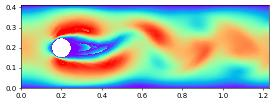

In [11]:
import matplotlib.pyplot as plt
from matplotlib import animation

from numpy import linspace
fig, ax = plt.subplots()
ax.set_xlim(( 0, 1.23))
ax.set_ylim(( 0, 0.41))
triangulation = gridView.triangulation(1)
levels = linspace(0, 2.0, 256)
ax.set_aspect('equal')
t        = 0.
stepsize = 0.1
nextstep = 0.
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=20, interval=100, blit=True)

try:
    movie = anim.to_html5_video()
    # save and embed
    anim.save('cylinder.gif', writer=animation.ImageMagickWriter(fps=2))
    from IPython.display import HTML, display
    display( HTML(movie) )
except:
    print("ffmpeg probably missing")
    try:
        anim.save("cylinder.html")
        from IPython.display import IFrame
        IFrame(src='./nice.html', width=700, height=600)
    except:
        pass

... if the movie is not showing you might have to rerun the notebook ...

Here is the velocity at the end of the simulation:

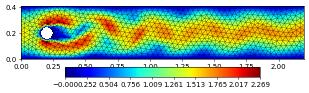

In [12]:
u_h.plot(colorbar="horizontal")